In [16]:
import nltk
import pandas as pd
import numpy as np
import re
import string
import time
from bs4 import BeautifulSoup
import requests
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 6]

In [3]:
dir = './scraping/scraped_data/'
file = '20170101wellness20200701.json'
articles = pd.read_json(dir+file)
articles.head()

,date,tags,title,author,claps,length,url
0,2017-01-01,"[mental-health, health, wellness, emotional, s...",How well are you? 8 Ways To Measure Your Well-...,Josephine Amoako,1,4,https://medium.com/@joseyphina/how-well-are-yo...
1,2017-01-02,"[fitness, health, wellness, weight, health-and...",How to Eat Healthy Foods on a Budget,Dacia Braxton,0,7,https://medium.com/@mensbodybuilding/how-to-ea...
2,2017-01-03,"[soul, wellness, peace, health]",Our health and wellness,Crown of Compassion,0,2,https://medium.com/@CrownofCompassion/our-heal...
3,2017-01-04,"[self-improvement, writing, self-awareness, we...",Wellness worksheets: a meditative writing aid,Laraine Domingo,2,3,https://medium.com/@brainoflaraine/wellness-wo...
4,2017-01-05,"[health, gluten, food, bread, wellness]",5 Reasons Why You’re Still Having Symptoms On ...,Mark Volmer,0,4,https://medium.com/@Flourish_Clinic/5-reasons-...


In [4]:
def get_corpus(ser):
    page_response = requests.get(str(ser))
    soup = BeautifulSoup(page_response.content, 'html.parser')
    corpus = ''
    for el in soup.find_all('p'):
        corpus += el.get_text()
    return corpus

start = time.time()
top_articles = articles.loc[articles['claps'] >= 500].copy()
top_articles['corpus'] = top_articles['url'].apply(get_corpus)
end = time.time()
print(end-start)

522.8484470844269


In [5]:
def clean(text):
    text = text.lower()
    text = re.sub('\n','',text) 
    text = re.sub('[.*?\â£]', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

top_articles['clean_corpus'] = top_articles['corpus'].apply(clean)
top_articles['clean_corpus'].iloc[0]

#clean_corpus = [clean(corpus)]
#clean_corpus

'no need to introduce the argan oil nowadays this ingredient is used in countless cosmetic products and its virtues have been recognized for centuries however how do we know which argan oil to choose and how do we use itargan oil its life its storythe argan oil comes from the argan a tree that grows mainly in morocco but also in some places in algeria this oil has been used by many generations of moroccan women to take care of their skin but also… to cook note that there are two kinds of argan oil and they are very differentargan oil how to choosefirst note that the argan oil is a fairly expensive ingredient it takes  of fruit to produce  of oil and the price of  is around  unfortunately we can find a lot of counterfeiting to be sure of getting real argan oil it is necessary that the description “ natural” be affixed on the packaging so you can be sure that you do not buy another disguised product be aware also that the oil must be clear and its smell must not be stubborn if so then th

In [6]:
def counter_df(clean_corpus):
    cv = CountVectorizer(ngram_range = (1,1), stop_words='english')
    data_cv = cv.fit_transform(clean_corpus)
    return pd.DataFrame(data={'word':cv.get_feature_names(), 'count':data_cv.toarray().sum(axis=0)})

data_df = counter_df(list(top_articles['clean_corpus']))
data_df.head()

#print(cv.get_feature_names())

,word,count
0,aa,9
1,aaa,1
2,abandon,4
3,abandoned,4
4,abandoning,1


In [7]:
# Correlating text to colors that affect mood
color_db = {
    'purple_neg': ['mystery', 'moodiness', 'boredom', 'confusion', 'disconnection'],
    'purple_pos': ['connection', 'wisdom', 'spirituality', 'royalty', 'nobility', 'luxury', 'ambition', 'wealth', 'awaken'],
    'blue_neg': ['coldness', 'masculinity', 'disgust', 'conflict', 'aggression'],
    'blue_pos': ['intuition', 'imagination', 'iranquility', 'security', 'integrity', 'peace', 'loyalty', 'faith', 'intelligence', 'spiritual'],
    'teal_neg': ['femininity', 'hostility', 'conflict', 'aggression', 'insecurity'],
    'teal_pos': ['communication', 'expression', 'spiritual', 'healing', 'protection', 'sophisticated', 'cleanse', 'expression'],
    'green_neg': ['envy', 'jealousy', 'guilt', 'fear', 'judgmental', 'unforgiving', 'anxiety'],
    'green_pos': ['compassion', 'trust', 'freshness', 'environment', 'new', 'money', 'fertile', 'health', 'grounded', 'reconnecting', 'balanced'],
    'yellow_neg': ['irresponsible', 'instability', 'grief', 'addiction', 'insecurity', 'depression'],
    'yellow_pos': ['confident', 'bright', 'sunny', 'energetic', 'warm', 'happy', 'perky', 'joy', 'intellect'],
    'orange_neg': ['ignorance', 'sluggishness', 'shame', 'compulsiveness', 'loneliness', 'dependence'],
    'orange_pos': ['courage', 'confidence', 'friendliness', 'success', 'creativity', 'openness', 'sexual'],
    'red_neg': ['anger', 'unsafe', 'warned', 'anxious', 'volatile', 'hopelessness'],
    'red_pos': ['love', 'passion', 'energy', 'power', 'strength', 'heat', 'desire', 'safe', 'instinctive', 'security', 'liberating']
}
def find_color(word):
    for key in color_db.keys():
        if word in color_db[key]:
            return key
    return ''
            
data_df['color'] = data_df['word'].apply(find_color)
data_count = data_df.groupby('color').sum()
data_count

,count
color,
,179935
blue_neg,15
blue_pos,114
green_neg,285
green_pos,1303
orange_neg,38
orange_pos,141
purple_neg,40
purple_pos,86


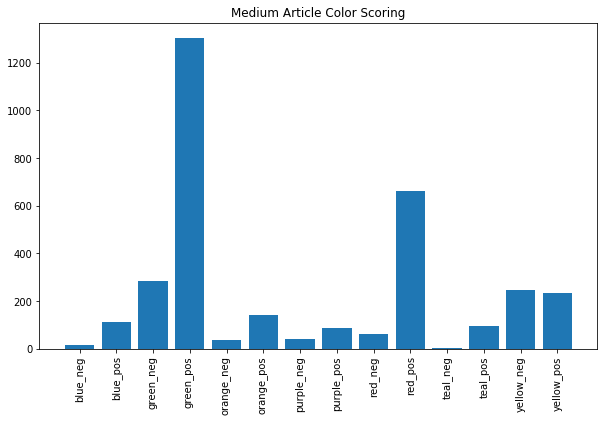

In [18]:
colors = list(data_count.index)[1:]
#['purple', 'blue', 'teal', 'green', 'yellow', 'orange', 'red']
scores = []
for i in range(len(colors)):
    if colors[i] in data_count.index:
        scores.append(data_count.loc[colors[i], 'count'])
    else:
        scores.append(0)
        
plt.bar(colors, scores)
plt.xticks(rotation='vertical')
plt.title('Medium Article Color Scoring')
plt.show()

In [20]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer()

cv_unigram = CountVectorizer(ngram_range = (1,1), stop_words='english')
cv_bigram = CountVectorizer(ngram_range = (2,2), stop_words='english')

def unigram_themes(data):
    data_cv_stop = cv_unigram.fit_transform(data)
    transformed_weights = transformer.fit_transform(data_cv_stop)
    weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({'term': cv_unigram.get_feature_names(), 'weight': weights})
    return weights_df.sort_values(by='weight', ascending=False).head(7)
    
def bigram_themes(data):
    data_cv_stop = cv_bigram.fit_transform(data)
    transformed_weights = transformer.fit_transform(data_cv_stop)
    weights = np.asarray(transformed_weights.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({'term': cv_bigram.get_feature_names(), 'weight': weights})
    return weights_df.sort_values(by='weight', ascending=False).head(7)


#unigram_themes(clean_corpus)
bigram_themes(list(top_articles['clean_corpus']))

,term,weight
87798,mental health,0.006051
151484,weight loss,0.004506
49156,feel like,0.004220
58292,green tea,0.004025
87806,mental illness,0.003798
38464,don want,0.003625
82443,lose weight,0.003556


In [21]:
from sklearn.decomposition import LatentDirichletAllocation as LDA
n_topics = 2
n_words = 4

cv = CountVectorizer(ngram_range = (1,1), stop_words = 'english')

def print_LDA_topics(model, count_vectorizer, n_top_words):
    words = cv.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]))
        

data_cv = cv.fit_transform(list(top_articles['clean_corpus']))
lda = LDA(n_components=n_topics, n_jobs=-1)
lda.fit(data_cv)
print_LDA_topics(lda, cv, n_words)


Topic #0:
like time people just

Topic #1:
health like time people
